Эта тетрадка будет посвящена созданию генеративной модели, которую мы обучим на собранном датасете, и Google Colaboratory(по той причине, что в данной среде предоставляется бесплатный GPU).

## Устанавливаем нужные зависимости

Для того, чтобы скачать датасет с нашего Google Drive в Colaboratory нужно установить `PyDrive`.

In [4]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Вместо `DRIVE_FILE_ID` вставьте id вашего файла с Гугл Диска(id записано в конце ссылки на ваш файл, при доступе к файлу по ссылке).

In [0]:
fileId = drive.CreateFile({'id': 'DRIVE_FILE_ID'}) #DRIVE_FILE_ID is file id example
fileId.GetContentFile('fish_big_dataset.zip')

Распакуем датасет!..

In [0]:
!unzip fish_big_dataset.zip -d ./

In [2]:
!ls

adc.json  dataset  dataset1  fish_big_dataset.zip  sample_data


В данном `notebook` мы будем использовать библиотеку `mxnet` для построения нейронных сетей.
<br>
Поэтому нужно установить следующую зависимость и саму библиотеку.

In [3]:
!apt install libnvrtc8.0
!pip install mxnet-cu80

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libnvrtc8.0 is already the newest version (8.0.61-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


## Перейдем к машинному обучению

Данная часть тетрадки будет основана на <a href="https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html">туториале от mxnet, посвященному DCGAN</a>.

Экспериментальным путем были подобраны иные значения `learning rate` и `beta1` для обучения DCGAN на собранном ранее датасете и использован метод `Nesterov ADAM` вместо `ADAM`; была применена иная функция активации в генераторе, реализованная в `mxnet`(подробнее - <a href='https://arxiv.org/abs/1710.05941'>Swish</a>).

In [0]:
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
%matplotlib inline

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np

In [0]:
epochs = 20
batch_size = 64
latent_z_size = 100

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5 * 2 / 3

Хоть наш датасет является коллекцией изображений `120x120`, давайте генерировать картинки `64x64` ради простоты.
<br>
<br>
Поэтому считаем изображения в память и преобразуем их к размеру `64x64`.
Также не будем считывать особенно много их из папки, в которой лежат изображения, созданные при помощи `imgaug`, в целях экономии времени обучения.

In [29]:
%%time
from tqdm import tqdm_notebook, tqdm

data_path = 'dataset'

target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32) / 127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    np.random.shuffle(fnames)
    for fname in tqdm(fnames):
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)

data_path = 'dataset1'
        
for path, _, fnames in os.walk(data_path):
    np.random.shuffle(fnames)
    for fname in tqdm(fnames[:500]):
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
        

np.random.shuffle(img_list)
        
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

CPU times: user 1min 36s, sys: 7.78 s, total: 1min 44s
Wall time: 57.5 s


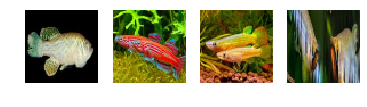

In [30]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

In [0]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Swish())
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Swish())
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Swish())
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Swish())
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

In [0]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'nadam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'nadam', {'learning_rate': lr * 3 / 2, 'beta1': beta1})






















  0%|          | 0/20 [00:00<?, ?it/s]INFO:root:speed: 136.46551981 samples/s
INFO:root:discriminator loss = 1.676721, generator loss = 6.319681, binary training acc = 0.492188 at iter 0 epoch 0
INFO:root:speed: 275.744335353 samples/s
INFO:root:discriminator loss = 0.565977, generator loss = 16.640764, binary training acc = 0.860795 at iter 10 epoch 0
INFO:root:speed: 286.050137412 samples/s
INFO:root:discriminator loss = 0.025737, generator loss = 6.712740, binary training acc = 0.855283 at iter 20 epoch 0
INFO:root:speed: 274.06754403 samples/s
INFO:root:discriminator loss = 2.453480, generator loss = 27.686884, binary training acc = 0.827369 at iter 30 epoch 0
INFO:root:speed: 260.034772635 samples/s
INFO:root:discriminator loss = 0.614661, generator loss = 1.564314, binary training acc = 0.820694 at iter 40 epoch 0
INFO:root:speed: 248.465535514 samples/s
INFO:root:discriminator loss = 0.843802, generator loss = 1.069022, binary training acc = 0.804228 at iter

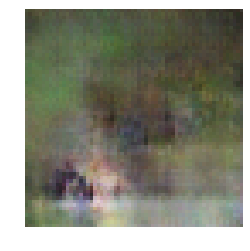






















  5%|▌         | 1/20 [04:49<1:31:48, 289.92s/it]INFO:root:speed: 622.658279055 samples/s
INFO:root:discriminator loss = 0.782903, generator loss = 2.468608, binary training acc = 0.937500 at iter 0 epoch 1
INFO:root:speed: 291.162114877 samples/s
INFO:root:discriminator loss = 1.325099, generator loss = 0.537905, binary training acc = 0.710938 at iter 10 epoch 1
INFO:root:speed: 276.460268205 samples/s
INFO:root:discriminator loss = 1.249541, generator loss = 0.600858, binary training acc = 0.721726 at iter 20 epoch 1
INFO:root:speed: 311.209668949 samples/s
INFO:root:discriminator loss = 1.030086, generator loss = 0.915346, binary training acc = 0.697329 at iter 30 epoch 1
INFO:root:speed: 332.671287593 samples/s
INFO:root:discriminator loss = 1.430900, generator loss = 0.596032, binary training acc = 0.705221 at iter 40 epoch 1
INFO:root:speed: 306.79109189 samples/s
INFO:root:discriminator loss = 1.296339, generator loss = 1.293819, binary training acc = 0.6925

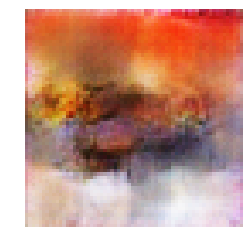






















 10%|█         | 2/20 [09:39<1:26:57, 289.84s/it]INFO:root:speed: 604.606147969 samples/s
INFO:root:discriminator loss = 0.523425, generator loss = 2.427534, binary training acc = 0.875000 at iter 0 epoch 2
INFO:root:speed: 294.87125363 samples/s
INFO:root:discriminator loss = 0.726357, generator loss = 1.443836, binary training acc = 0.822443 at iter 10 epoch 2
INFO:root:speed: 290.976850668 samples/s
INFO:root:discriminator loss = 0.914828, generator loss = 1.353352, binary training acc = 0.769345 at iter 20 epoch 2
INFO:root:speed: 241.299190352 samples/s
INFO:root:discriminator loss = 0.771566, generator loss = 1.506987, binary training acc = 0.749748 at iter 30 epoch 2
INFO:root:speed: 280.716523172 samples/s
INFO:root:discriminator loss = 1.177098, generator loss = 0.648424, binary training acc = 0.761433 at iter 40 epoch 2
INFO:root:speed: 299.424716454 samples/s
INFO:root:discriminator loss = 0.583406, generator loss = 1.987359, binary training acc = 0.7754

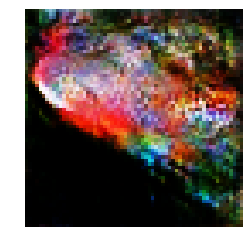






















 15%|█▌        | 3/20 [14:29<1:22:06, 289.79s/it]INFO:root:speed: 524.211211248 samples/s
INFO:root:discriminator loss = 0.477808, generator loss = 2.671321, binary training acc = 0.906250 at iter 0 epoch 3
INFO:root:speed: 256.035649495 samples/s
INFO:root:discriminator loss = 0.497918, generator loss = 2.562301, binary training acc = 0.869318 at iter 10 epoch 3
INFO:root:speed: 302.457373678 samples/s
INFO:root:discriminator loss = 0.625751, generator loss = 5.325980, binary training acc = 0.893601 at iter 20 epoch 3
INFO:root:speed: 300.929862559 samples/s
INFO:root:discriminator loss = 0.498787, generator loss = 3.987124, binary training acc = 0.859879 at iter 30 epoch 3
INFO:root:speed: 315.449775019 samples/s
INFO:root:discriminator loss = 0.629733, generator loss = 4.832603, binary training acc = 0.871189 at iter 40 epoch 3
INFO:root:speed: 349.308834629 samples/s
INFO:root:discriminator loss = 0.508636, generator loss = 3.769707, binary training acc = 0.871

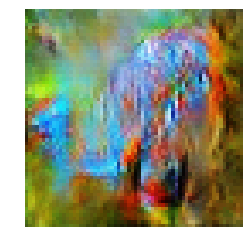






















 20%|██        | 4/20 [19:18<1:17:15, 289.74s/it]INFO:root:speed: 628.597050855 samples/s
INFO:root:discriminator loss = 0.347998, generator loss = 4.415048, binary training acc = 0.976562 at iter 0 epoch 4
INFO:root:speed: 285.627671154 samples/s
INFO:root:discriminator loss = 0.501762, generator loss = 5.013503, binary training acc = 0.941051 at iter 10 epoch 4
INFO:root:speed: 311.399204204 samples/s
INFO:root:discriminator loss = 0.576071, generator loss = 2.114444, binary training acc = 0.906622 at iter 20 epoch 4
INFO:root:speed: 269.371522039 samples/s
INFO:root:discriminator loss = 0.621815, generator loss = 1.914648, binary training acc = 0.871220 at iter 30 epoch 4
INFO:root:speed: 251.210927542 samples/s
INFO:root:discriminator loss = 0.641325, generator loss = 1.478730, binary training acc = 0.883956 at iter 40 epoch 4
INFO:root:speed: 284.089647866 samples/s
INFO:root:discriminator loss = 0.398169, generator loss = 2.206393, binary training acc = 0.877

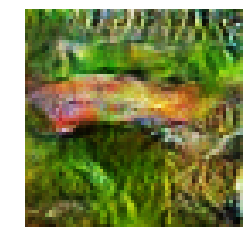






















 25%|██▌       | 5/20 [24:08<1:12:26, 289.76s/it]INFO:root:speed: 604.641556183 samples/s
INFO:root:discriminator loss = 1.844470, generator loss = 8.211746, binary training acc = 0.632812 at iter 0 epoch 5
INFO:root:speed: 247.236188976 samples/s
INFO:root:discriminator loss = 0.375398, generator loss = 5.685003, binary training acc = 0.914773 at iter 10 epoch 5
INFO:root:speed: 284.251192342 samples/s
INFO:root:discriminator loss = 0.237988, generator loss = 4.854965, binary training acc = 0.916295 at iter 20 epoch 5
INFO:root:speed: 285.556267579 samples/s
INFO:root:discriminator loss = 0.323362, generator loss = 2.686830, binary training acc = 0.924395 at iter 30 epoch 5
INFO:root:speed: 331.582325686 samples/s
INFO:root:discriminator loss = 0.295395, generator loss = 2.981501, binary training acc = 0.938262 at iter 40 epoch 5
INFO:root:speed: 256.072530309 samples/s
INFO:root:discriminator loss = 1.252426, generator loss = 7.603275, binary training acc = 0.929

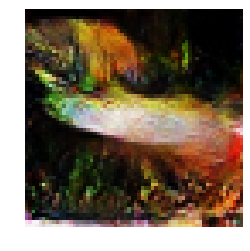






















 30%|███       | 6/20 [28:58<1:07:36, 289.76s/it]INFO:root:speed: 457.475959269 samples/s
INFO:root:discriminator loss = 0.796715, generator loss = 8.345758, binary training acc = 0.859375 at iter 0 epoch 6
INFO:root:speed: 288.476495065 samples/s
INFO:root:discriminator loss = 0.138169, generator loss = 4.202708, binary training acc = 0.948864 at iter 10 epoch 6
INFO:root:speed: 299.409353633 samples/s
INFO:root:discriminator loss = 0.180946, generator loss = 4.182297, binary training acc = 0.962054 at iter 20 epoch 6
INFO:root:speed: 301.475683537 samples/s
INFO:root:discriminator loss = 0.142728, generator loss = 3.701706, binary training acc = 0.967490 at iter 30 epoch 6
INFO:root:speed: 264.016609998 samples/s
INFO:root:discriminator loss = 0.211263, generator loss = 4.296259, binary training acc = 0.971608 at iter 40 epoch 6
INFO:root:speed: 242.552003997 samples/s
INFO:root:discriminator loss = 0.268734, generator loss = 3.326493, binary training acc = 0.973

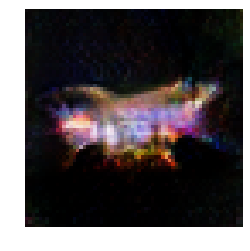






















 35%|███▌      | 7/20 [33:48<1:02:47, 289.81s/it]INFO:root:speed: 467.757822669 samples/s
INFO:root:discriminator loss = 0.096267, generator loss = 5.209385, binary training acc = 1.000000 at iter 0 epoch 7
INFO:root:speed: 300.368200088 samples/s
INFO:root:discriminator loss = 0.508997, generator loss = 9.596170, binary training acc = 0.978693 at iter 10 epoch 7
INFO:root:speed: 290.375974237 samples/s
INFO:root:discriminator loss = 0.343525, generator loss = 5.009296, binary training acc = 0.870164 at iter 20 epoch 7
INFO:root:speed: 307.848004642 samples/s
INFO:root:discriminator loss = 0.146183, generator loss = 4.251223, binary training acc = 0.898438 at iter 30 epoch 7
INFO:root:speed: 293.278169941 samples/s
INFO:root:discriminator loss = 0.201588, generator loss = 4.302878, binary training acc = 0.909680 at iter 40 epoch 7
INFO:root:speed: 278.693321069 samples/s
INFO:root:discriminator loss = 0.259935, generator loss = 3.695422, binary training acc = 0.918

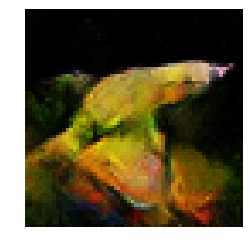






















 40%|████      | 8/20 [38:38<57:57, 289.79s/it]  INFO:root:speed: 477.62616277 samples/s
INFO:root:discriminator loss = 0.053345, generator loss = 5.060694, binary training acc = 0.992188 at iter 0 epoch 8
INFO:root:speed: 244.266506513 samples/s
INFO:root:discriminator loss = 0.055871, generator loss = 5.058144, binary training acc = 0.999290 at iter 10 epoch 8
INFO:root:speed: 294.220660462 samples/s
INFO:root:discriminator loss = 0.040943, generator loss = 5.142398, binary training acc = 0.998512 at iter 20 epoch 8
INFO:root:speed: 261.939615476 samples/s
INFO:root:discriminator loss = 0.075797, generator loss = 4.704529, binary training acc = 0.996724 at iter 30 epoch 8
INFO:root:speed: 242.609877184 samples/s
INFO:root:discriminator loss = 0.514528, generator loss = 1.471034, binary training acc = 0.986090 at iter 40 epoch 8
INFO:root:speed: 287.675479762 samples/s
INFO:root:discriminator loss = 1.541453, generator loss = 3.202180, binary training acc = 0.9114

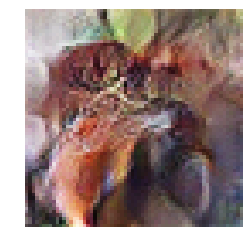






















 45%|████▌     | 9/20 [43:27<53:07, 289.78s/it]INFO:root:speed: 530.944509386 samples/s
INFO:root:discriminator loss = 0.063700, generator loss = 5.337924, binary training acc = 1.000000 at iter 0 epoch 9
INFO:root:speed: 267.405410359 samples/s
INFO:root:discriminator loss = 0.049560, generator loss = 5.207665, binary training acc = 0.999290 at iter 10 epoch 9
INFO:root:speed: 291.558683641 samples/s
INFO:root:discriminator loss = 0.053121, generator loss = 5.194186, binary training acc = 0.998512 at iter 20 epoch 9
INFO:root:speed: 287.282940601 samples/s
INFO:root:discriminator loss = 0.022622, generator loss = 5.651227, binary training acc = 0.998488 at iter 30 epoch 9
INFO:root:speed: 280.695681998 samples/s
INFO:root:discriminator loss = 0.064536, generator loss = 5.518678, binary training acc = 0.998666 at iter 40 epoch 9
INFO:root:speed: 276.668273824 samples/s
INFO:root:discriminator loss = 0.064663, generator loss = 5.227071, binary training acc = 0.99846

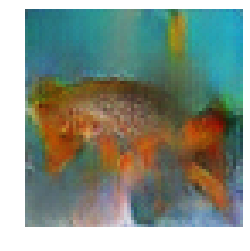






















 50%|█████     | 10/20 [48:17<48:17, 289.75s/it]INFO:root:speed: 595.127991043 samples/s
INFO:root:discriminator loss = 0.067135, generator loss = 5.561189, binary training acc = 1.000000 at iter 0 epoch 10
INFO:root:speed: 263.454583642 samples/s
INFO:root:discriminator loss = 0.073521, generator loss = 5.736269, binary training acc = 0.997869 at iter 10 epoch 10
INFO:root:speed: 294.205504555 samples/s
INFO:root:discriminator loss = 0.066580, generator loss = 5.435131, binary training acc = 0.995908 at iter 20 epoch 10
INFO:root:speed: 279.379592788 samples/s
INFO:root:discriminator loss = 0.060017, generator loss = 5.598116, binary training acc = 0.994708 at iter 30 epoch 10
INFO:root:speed: 257.478954068 samples/s
INFO:root:discriminator loss = 0.083001, generator loss = 5.211229, binary training acc = 0.994474 at iter 40 epoch 10
INFO:root:speed: 265.035579585 samples/s
INFO:root:discriminator loss = 0.073486, generator loss = 4.905611, binary training acc = 0

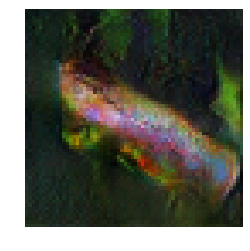






















 55%|█████▌    | 11/20 [53:07<43:28, 289.79s/it]INFO:root:speed: 630.952193586 samples/s
INFO:root:discriminator loss = 0.031110, generator loss = 5.439049, binary training acc = 1.000000 at iter 0 epoch 11
INFO:root:speed: 284.239754849 samples/s
INFO:root:discriminator loss = 0.059696, generator loss = 6.298768, binary training acc = 0.998580 at iter 10 epoch 11
INFO:root:speed: 259.011828639 samples/s
INFO:root:discriminator loss = 0.062523, generator loss = 5.937516, binary training acc = 0.998140 at iter 20 epoch 11
INFO:root:speed: 314.395706793 samples/s
INFO:root:discriminator loss = 0.027708, generator loss = 5.895794, binary training acc = 0.997228 at iter 30 epoch 11
INFO:root:speed: 279.30401306 samples/s
INFO:root:discriminator loss = 0.079292, generator loss = 4.962090, binary training acc = 0.997904 at iter 40 epoch 11
INFO:root:speed: 262.339217269 samples/s
INFO:root:discriminator loss = 0.065907, generator loss = 5.315746, binary training acc = 0.

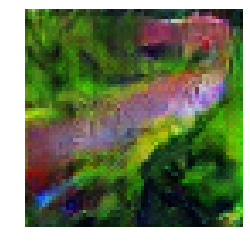






















 60%|██████    | 12/20 [57:57<38:37, 289.75s/it]INFO:root:speed: 610.396878382 samples/s
INFO:root:discriminator loss = 0.025793, generator loss = 6.016761, binary training acc = 1.000000 at iter 0 epoch 12
INFO:root:speed: 285.899330718 samples/s
INFO:root:discriminator loss = 0.045724, generator loss = 6.029878, binary training acc = 0.998580 at iter 10 epoch 12
INFO:root:speed: 288.227149688 samples/s
INFO:root:discriminator loss = 0.042991, generator loss = 5.444572, binary training acc = 0.997768 at iter 20 epoch 12
INFO:root:speed: 298.632585812 samples/s
INFO:root:discriminator loss = 0.032721, generator loss = 5.897480, binary training acc = 0.993196 at iter 30 epoch 12
INFO:root:speed: 326.483981411 samples/s
INFO:root:discriminator loss = 0.078861, generator loss = 5.232990, binary training acc = 0.994284 at iter 40 epoch 12
INFO:root:speed: 290.086340078 samples/s
INFO:root:discriminator loss = 0.133535, generator loss = 4.527950, binary training acc = 0

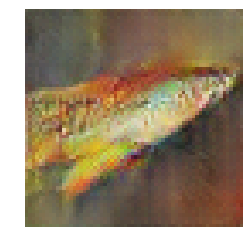






















 65%|██████▌   | 13/20 [1:02:46<33:47, 289.68s/it]INFO:root:speed: 598.370204921 samples/s
INFO:root:discriminator loss = 0.108338, generator loss = 4.740359, binary training acc = 0.992188 at iter 0 epoch 13
INFO:root:speed: 331.927964823 samples/s
INFO:root:discriminator loss = 0.147649, generator loss = 7.370010, binary training acc = 0.982955 at iter 10 epoch 13
INFO:root:speed: 331.247624254 samples/s
INFO:root:discriminator loss = 0.045474, generator loss = 5.373847, binary training acc = 0.986607 at iter 20 epoch 13
INFO:root:speed: 273.157530225 samples/s
INFO:root:discriminator loss = 0.067007, generator loss = 5.430385, binary training acc = 0.987903 at iter 30 epoch 13
INFO:root:speed: 269.757537692 samples/s
INFO:root:discriminator loss = 0.217192, generator loss = 3.354487, binary training acc = 0.987614 at iter 40 epoch 13
INFO:root:speed: 266.896795971 samples/s
INFO:root:discriminator loss = 0.089998, generator loss = 7.062606, binary training acc =

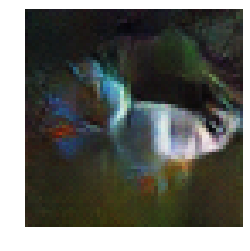






















 70%|███████   | 14/20 [1:07:36<28:58, 289.72s/it]INFO:root:speed: 565.291507849 samples/s
INFO:root:discriminator loss = 0.019297, generator loss = 6.621768, binary training acc = 1.000000 at iter 0 epoch 14
INFO:root:speed: 282.987821745 samples/s
INFO:root:discriminator loss = 0.017350, generator loss = 6.388673, binary training acc = 1.000000 at iter 10 epoch 14
INFO:root:speed: 286.280462339 samples/s
INFO:root:discriminator loss = 0.025101, generator loss = 6.354583, binary training acc = 1.000000 at iter 20 epoch 14
INFO:root:speed: 331.497972869 samples/s
INFO:root:discriminator loss = 0.017593, generator loss = 6.300576, binary training acc = 1.000000 at iter 30 epoch 14
INFO:root:speed: 281.63926817 samples/s
INFO:root:discriminator loss = 0.045637, generator loss = 5.502120, binary training acc = 1.000000 at iter 40 epoch 14
INFO:root:speed: 310.919495923 samples/s
INFO:root:discriminator loss = 0.021435, generator loss = 6.003611, binary training acc = 

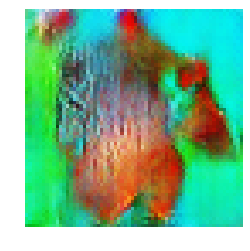






















 75%|███████▌  | 15/20 [1:12:26<24:08, 289.76s/it]INFO:root:speed: 553.518535473 samples/s
INFO:root:discriminator loss = 0.055978, generator loss = 5.746113, binary training acc = 0.992188 at iter 0 epoch 15
INFO:root:speed: 288.367721261 samples/s
INFO:root:discriminator loss = 0.029674, generator loss = 5.974468, binary training acc = 0.992898 at iter 10 epoch 15
INFO:root:speed: 283.145725898 samples/s
INFO:root:discriminator loss = 0.023437, generator loss = 6.456020, binary training acc = 0.994420 at iter 20 epoch 15
INFO:root:speed: 276.608404529 samples/s
INFO:root:discriminator loss = 0.015125, generator loss = 6.151172, binary training acc = 0.995716 at iter 30 epoch 15
INFO:root:speed: 273.931620024 samples/s
INFO:root:discriminator loss = 0.030836, generator loss = 5.936331, binary training acc = 0.996761 at iter 40 epoch 15
INFO:root:speed: 273.62000791 samples/s
INFO:root:discriminator loss = 0.046023, generator loss = 7.564441, binary training acc = 

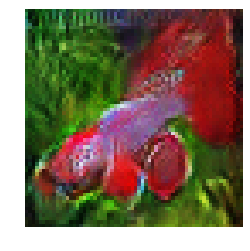






















 80%|████████  | 16/20 [1:17:16<19:19, 289.81s/it]INFO:root:speed: 597.35953891 samples/s
INFO:root:discriminator loss = 0.011717, generator loss = 6.374291, binary training acc = 1.000000 at iter 0 epoch 16
INFO:root:speed: 267.579736004 samples/s
INFO:root:discriminator loss = 0.022966, generator loss = 6.486585, binary training acc = 1.000000 at iter 10 epoch 16
INFO:root:speed: 258.621295094 samples/s
INFO:root:discriminator loss = 0.014155, generator loss = 6.688995, binary training acc = 1.000000 at iter 20 epoch 16
INFO:root:speed: 312.45251675 samples/s
INFO:root:discriminator loss = 0.027016, generator loss = 7.508780, binary training acc = 0.999748 at iter 30 epoch 16
INFO:root:speed: 290.693886922 samples/s
INFO:root:discriminator loss = 0.063852, generator loss = 6.864776, binary training acc = 0.998476 at iter 40 epoch 16
INFO:root:speed: 272.794161106 samples/s
INFO:root:discriminator loss = 0.039071, generator loss = 5.778562, binary training acc = 0

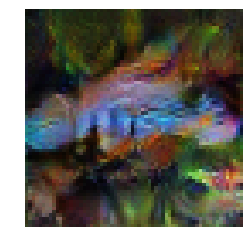






















 85%|████████▌ | 17/20 [1:22:05<14:29, 289.80s/it]INFO:root:speed: 475.232328526 samples/s
INFO:root:discriminator loss = 0.016610, generator loss = 6.669189, binary training acc = 1.000000 at iter 0 epoch 17
INFO:root:speed: 279.237188149 samples/s
INFO:root:discriminator loss = 0.012811, generator loss = 7.264424, binary training acc = 0.999290 at iter 10 epoch 17
INFO:root:speed: 262.683732983 samples/s
INFO:root:discriminator loss = 0.019059, generator loss = 6.521625, binary training acc = 0.999628 at iter 20 epoch 17
INFO:root:speed: 294.751779093 samples/s
INFO:root:discriminator loss = 0.006619, generator loss = 7.216763, binary training acc = 0.999748 at iter 30 epoch 17
INFO:root:speed: 264.942454678 samples/s
INFO:root:discriminator loss = 0.035258, generator loss = 5.679469, binary training acc = 0.999809 at iter 40 epoch 17
INFO:root:speed: 284.967564274 samples/s
INFO:root:discriminator loss = 0.013536, generator loss = 6.637249, binary training acc =

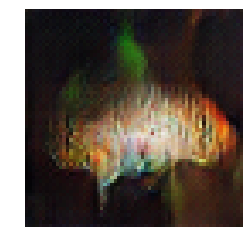






















 90%|█████████ | 18/20 [1:26:55<09:39, 289.78s/it]INFO:root:speed: 551.615596905 samples/s
INFO:root:discriminator loss = 0.029354, generator loss = 7.229997, binary training acc = 1.000000 at iter 0 epoch 18
INFO:root:speed: 293.183996715 samples/s
INFO:root:discriminator loss = 0.032573, generator loss = 5.975947, binary training acc = 0.999290 at iter 10 epoch 18
INFO:root:speed: 332.94485306 samples/s
INFO:root:discriminator loss = 0.129478, generator loss = 5.955197, binary training acc = 0.992560 at iter 20 epoch 18
INFO:root:speed: 262.62770689 samples/s
INFO:root:discriminator loss = 0.074828, generator loss = 7.000194, binary training acc = 0.993952 at iter 30 epoch 18
INFO:root:speed: 256.18323653 samples/s
INFO:root:discriminator loss = 0.054989, generator loss = 5.634829, binary training acc = 0.995236 at iter 40 epoch 18
INFO:root:speed: 301.060476676 samples/s
INFO:root:discriminator loss = 0.025667, generator loss = 6.470117, binary training acc = 0.

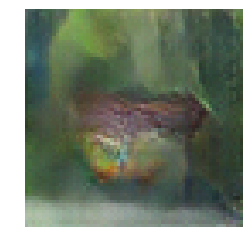






















 95%|█████████▌| 19/20 [1:31:45<04:49, 289.77s/it]INFO:root:speed: 593.934998816 samples/s
INFO:root:discriminator loss = 0.048243, generator loss = 6.498805, binary training acc = 1.000000 at iter 0 epoch 19
INFO:root:speed: 287.421976954 samples/s
INFO:root:discriminator loss = 0.026829, generator loss = 6.934301, binary training acc = 0.998580 at iter 10 epoch 19
INFO:root:speed: 276.170437617 samples/s
INFO:root:discriminator loss = 0.040623, generator loss = 6.359686, binary training acc = 0.998512 at iter 20 epoch 19
INFO:root:speed: 289.136159327 samples/s
INFO:root:discriminator loss = 0.017961, generator loss = 6.943181, binary training acc = 0.997228 at iter 30 epoch 19
INFO:root:speed: 295.016761201 samples/s
INFO:root:discriminator loss = 0.097816, generator loss = 6.905137, binary training acc = 0.996380 at iter 40 epoch 19
INFO:root:speed: 252.666775225 samples/s
INFO:root:discriminator loss = 0.060998, generator loss = 5.878182, binary training acc =

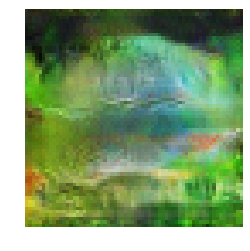






















100%|██████████| 20/20 [1:36:35<00:00, 289.78s/it]






















In [102]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in tqdm(range(epochs)):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    fake_img = fake[0]
    visualize(fake_img)
    plt.show()

In [ ]:
def random_pics(size=(12, 12), num_image=16)
    plt.figure(figsize=size)
    n = int(np.sqrt(num_image))
    for i in range(num_image):
        latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
        img = netG(latent_z)
        plt.subplot(n, n, i + 1)
        visualize(img[0])
    plt.show()
    
def random_pics_with_step(size=(12, 12), num_image=16, step=0.1):
    plt.figure(figsize=size)
    n = int(np.sqrt(num_image))
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    for i in range(num_image):
        img = netG(latent_z)
        plt.subplot(n, n, i + 1)
        visualize(img[0])
        latent_z += step
    plt.show() 

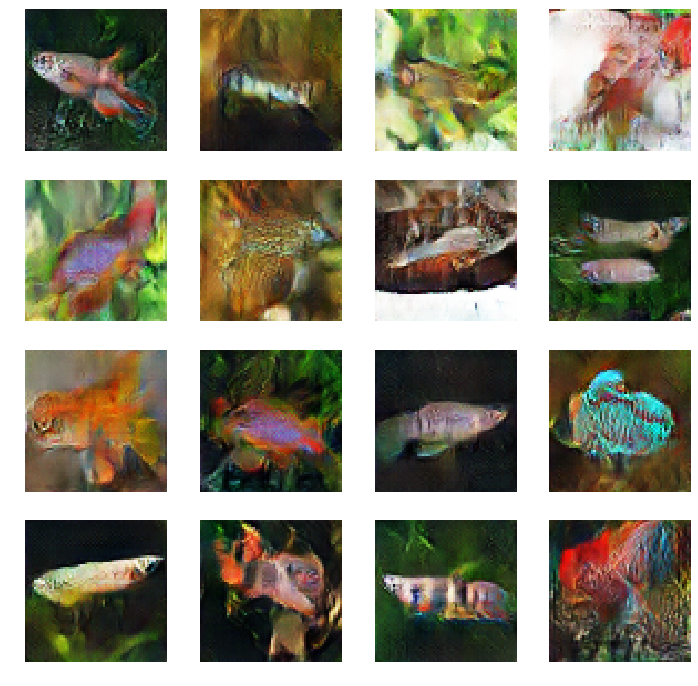

In [220]:
random_pics()

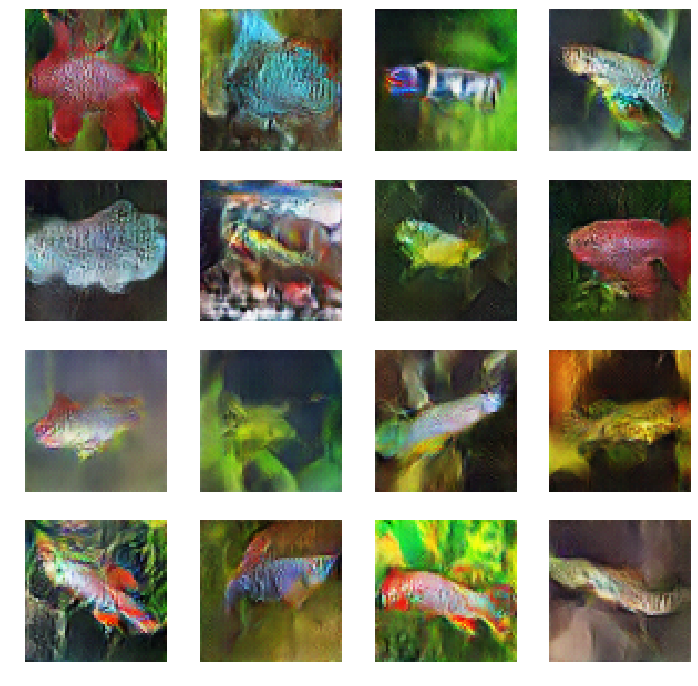

In [268]:
random_pics()

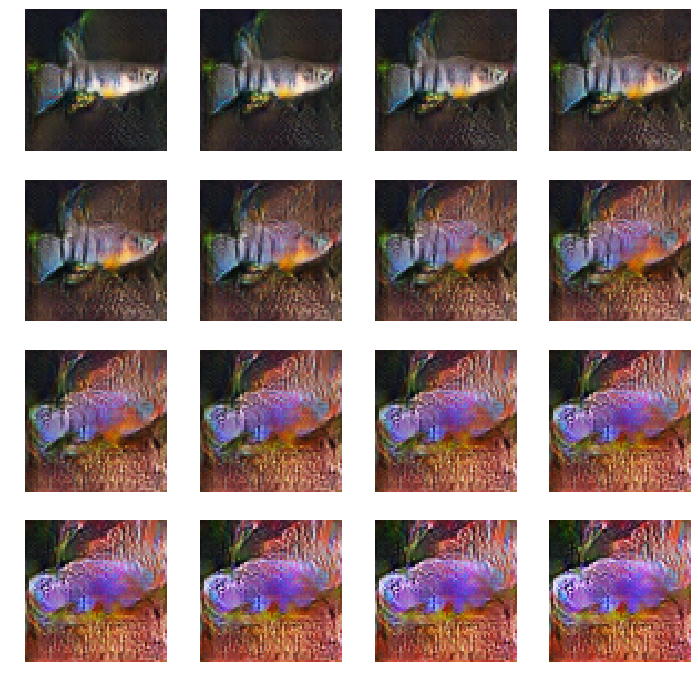

In [261]:
random_pics_with_step()

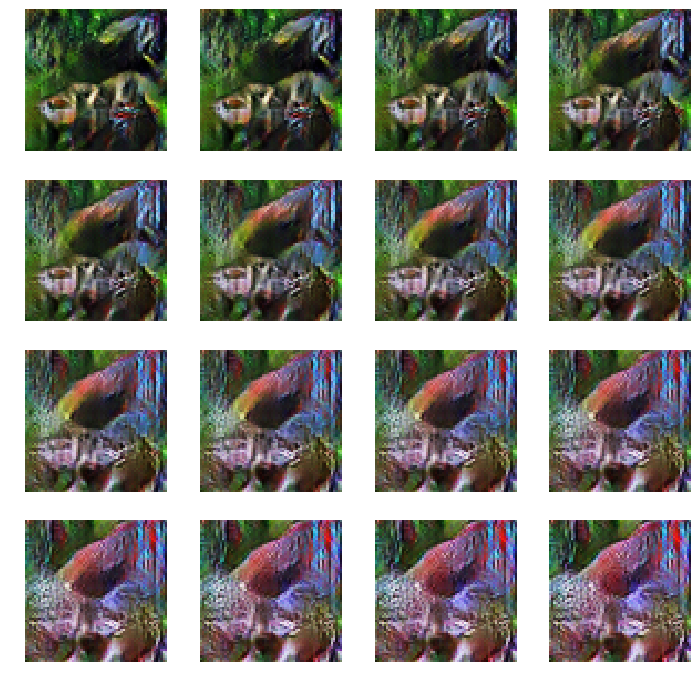

In [267]:
random_pics_with_step()

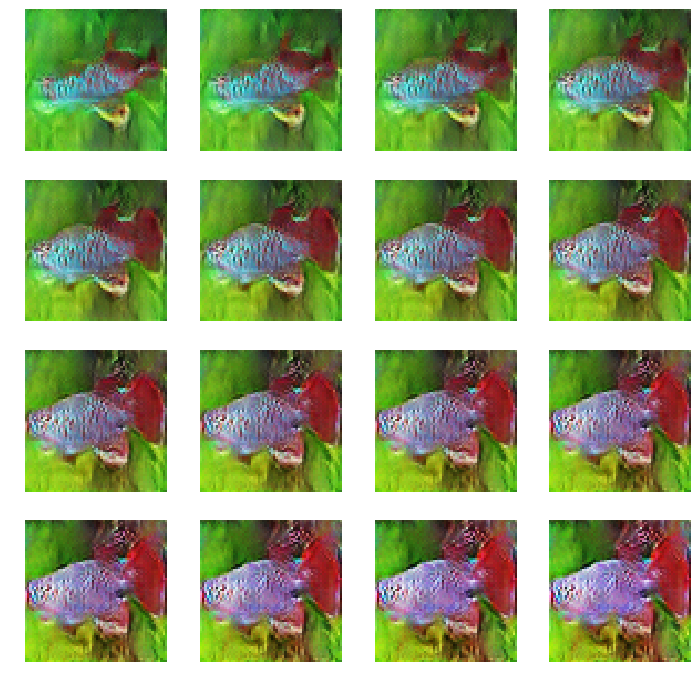

In [263]:
random_pics_with_step()

In [0]:
filename1 = 'generator.params'
filename2 = 'discriminator.params'

netG.save_parameters(filename1)
netD.save_parameters(filename2)

Теперь скачаем параметры обученной сети, т.к. виртуальная машина, выделяемая Google умирает через 12 часов:

In [0]:
from google.colab import files

files.download(filename1)
files.download(filename2)

Теперь мы можем использовать полученную нейросеть для формирования нового датасета(но это надо будет делать очень осторожно)!